# Influential NLP Papers on Google Scholar
Natural language processing (NLP) is a complex and evolving field. Part computer science, part linguistics, part statistics--it can be a challenge knowing where to begin. So how do we identify the right place to start learning? One way is to identify the most influential academic papers about NLP and use them as a guide.

There are a variety of sources to find academic papers online, but one of the best is Google Scholar, which conveniently provides data on how often a given paper or book is cited in other papers. Citation totals and citation rates are one indicator for how influential an academic work has been in its field. So, let's see what we can learn by exploring NLP papers on Google Scholar.

In [1]:
# load libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

# set styles
sns.set_style("darkgrid")

## Data Acquisition
Although Google Scholar is a fantastic search tool for academic papers, it is notoriously difficult to mine for data. Unfortunately, Google does not provide an API. It also enforces strict limits on automated web scraping. Thankfully, for our purposes we only need a small amount of data.

A simplistic way to get our data is to search for the term "natural language processing" in Google Scholar and manually save the HTML files for the first 100 pages. Don't worry, this part is already complete! You can find the HTML files for the first 98 search result pages in the `data` directory. (At the time of writing, pages 99 and 100 returned server errors.)

Once the data is saved, we can read it into a list of texts. Or, if you prefer, a .csv file is available in `data/gs_nlp_papers.csv`.

In [3]:
def load_docs(dir_path):
    """
    - Parameters: dir_path (string) for a directory containing text files.
    - Returns: A list of dictionaries with keys file_name and text.
    """
    docs = []
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if file_name.endswith(".html") and os.path.isfile(file_path):
            with open(file_path, "r+", encoding="utf-8") as file:
                text = file.read()
                current = {
                    "file_name": file_name,
                    "text": text
                }
                docs.append(current)
    return docs

html_docs = load_docs("data")
html_docs = sorted(html_docs, key = lambda d: d["file_name"])

## Data Extraction
Now that we have our data loaded, we need to extract the portions that we care about. To do so, we'll use *Beautiful Soup*, Python's premier web scraping library, to parse the HTML documents. As we parse each document, we'll create a *Pandas* dataframe for easy manipulation of the data and then concatenate all of the dataframes together so that we can work with a single data structure.

In [41]:
def extract_paper_data(paper):
    """
    - Parameters: paper (BeautifulSoup object)
    - Returns: A dictionary of paper attributes.
    """
    title_anchor = paper.find("h3").find("a")
    author_info = paper.find(class_="gs_a")
    authors = author_info.text.split("-")[0].strip().split(", ")
    year = "".join(re.findall(r' \d{4}', author_info.text))[-4:]
    blurb = paper.find(class_="gs_rs")
    usage_data = paper.find(class_="gs_fl")
    citation_anchor = usage_data.find_all("a")[2]
    num_cites = int("".join(re.findall(r'\d*', citation_anchor.text)))
    
    return {
        "title": title_anchor.text if title_anchor else "",
        "authors": authors,
        "blurb": blurb.text if blurb else "",
        "citations": num_cites,
        "year": int(year) if year != "" else "",
        "link": title_anchor["href"] if title_anchor else ""
    }

def paper_df(paper_html):
    """
    - Parameters: paper_html (string of html text)
    - Returns: A Pandas DataFrame with data for each paper.
    """
    paper_soup = BeautifulSoup(paper_html, "html.parser")
    all_paper_data = []
    results = paper_soup.find(id="gs_res_ccl_mid")
    papers = results.find_all("div", class_="gs_ri")

    for paper in papers:
        paper_data = extract_paper_data(paper)
        all_paper_data.append(paper_data)
    
    return pd.DataFrame(all_paper_data)

def load_papers(html_docs):
    """
    - Parameters: html_docs (a list of dictionaries)
      Dictionaries must have "file_name" and "text" sections.
    - Returns: A Pandas DataFrame with data from each of the papers.
    """
    all_dfs = []
    for entry in html_docs:
        df = paper_df(entry["text"])
        all_dfs.append(df)
    
    full_df = pd.concat(all_dfs).sort_values("title")
    full_df = full_df.reset_index(drop=True)
    return full_df

def clean_papers(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe without rows that contain empty cells.
    """
    clean_df = papers_df.copy()
    clean_df = clean_df.replace("", np.nan, regex=True)
    clean_df = clean_df.dropna()
    return clean_df

papers = load_papers(html_docs)
papers = clean_papers(papers)

## Data Exploration
As with any data project, let's start by taking a quick look at the structure of our data by checking the columns, data types, shape, and first few entries.

In [42]:
def print_df_info(df):
    """
    - Parameters: df (Pandas DataFrame)
    - Prints basic details about df.
    """
    print("DataFrame info:\n")
    print(df.info())
    print("\n")
    print(f'DataFrame shape: {df.shape}')
    print("\n")
    print("DataFrame head:")
    display(df.head())

print_df_info(papers)

DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 7 to 979
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      973 non-null    object
 1   authors    973 non-null    object
 2   blurb      973 non-null    object
 3   citations  973 non-null    int64 
 4   year       973 non-null    int64 
 5   link       973 non-null    object
dtypes: int64(2), object(4)
memory usage: 53.2+ KB
None


DataFrame shape: (973, 6)


DataFrame head:


,title,authors,blurb,citations,year,link
7,""" I'm sorry Dave, I'm afraid I can't do that"":...",[L Lee],According to many pop-culture visions of the f...,46,2003,https://arxiv.org/abs/cs/0304027
8,12 On the Use of Sequential Transducers in Nat...,[M Mohri],Finite-state machines have been used in variou...,38,1997,https://books.google.com/books?hl=en&lr=&id=q4...
9,36. NATURAL LANGUAGE PROCESSING IN COMPUTER-AS...,[J Nerbonne],Page 1. 36. NATURAL LANGUAGE PROCESSING IN COM...,49,2003,http://www.academia.edu/download/31147620/nlp-...
10,"A ""natural logic"" for natural language process...",[SS Ali],We de ne a knowledge representation and infere...,25,1993,http://citeseerx.ist.psu.edu/viewdoc/download?...
11,A Deep Learning Architecture for Psychometric ...,"[F Ahmad, A Abbasi, J Li, DG Dobolyi]",Psychometric measures reflecting people's know...,6,2020,https://dl.acm.org/doi/abs/10.1145/3365211


It looks like we have 973 total papers (since we removed a few rows that had empty cells). We also have the title, blurb, year of publication, and link for each paper. One thing seems to be missing from our data though. We have the number of citations for each paper, but is that the right metric? Some papers are older than others, which means they have had more time to gather citations. Let's add a `citation_rate` column that shows the number of citations per year since publication.

In [43]:
def get_citation_rate(citations, year_published):
    """
    - Parameters: citations (int), year_published (int)
    - Returns: The number of citations per year, since the year published.
    """
    current_year = pd.datetime.now().year
    years_since_publish = current_year - year_published
    return citations / (years_since_publish + 1)

papers["citation_rate"] = get_citation_rate(
    papers["citations"], papers["year"])
papers = papers[["title", "authors", "blurb", "citations",
                "citation_rate", "year", "link"]]
                
display(papers.head())

,title,authors,blurb,citations,citation_rate,year,link
7,""" I'm sorry Dave, I'm afraid I can't do that"":...",[L Lee],According to many pop-culture visions of the f...,46,2.555556,2003,https://arxiv.org/abs/cs/0304027
8,12 On the Use of Sequential Transducers in Nat...,[M Mohri],Finite-state machines have been used in variou...,38,1.583333,1997,https://books.google.com/books?hl=en&lr=&id=q4...
9,36. NATURAL LANGUAGE PROCESSING IN COMPUTER-AS...,[J Nerbonne],Page 1. 36. NATURAL LANGUAGE PROCESSING IN COM...,49,2.722222,2003,http://www.academia.edu/download/31147620/nlp-...
10,"A ""natural logic"" for natural language process...",[SS Ali],We de ne a knowledge representation and infere...,25,0.892857,1993,http://citeseerx.ist.psu.edu/viewdoc/download?...
11,A Deep Learning Architecture for Psychometric ...,"[F Ahmad, A Abbasi, J Li, DG Dobolyi]",Psychometric measures reflecting people's know...,6,6.000000,2020,https://dl.acm.org/doi/abs/10.1145/3365211


Great! Now we have at least two metrics to use when judging how influential a particular paper has been in the world of NLP: total citations; and, citation rate since year of publication.

## NLP Research Over Time

Before we start exploring individual papers it would be useful to get a high-level view of our data. When were the most influential NLP papers produced? How has that trend changed over time?

To get our high-level overview, let's plot the production of NLP papers by year.

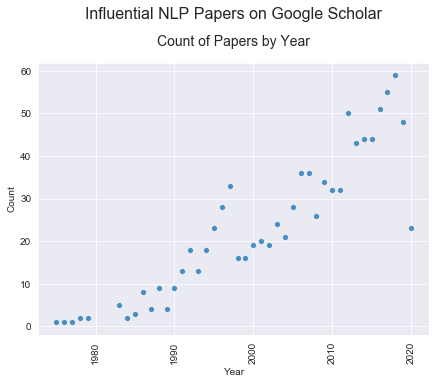

In [49]:
def plot_count_by_year(df, title, subtitle, year_col="year"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), 
      year_col (str)
    - Plots a scatterplot of the count of rows in df, grouped by year_col.
    """
    counts = df.groupby(year_col).size().reset_index(name="count")
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(
        x="year",
        y="count",
        data=counts,
        alpha=0.8,
        ax=ax
    )
    ax.set(
        xlabel="Year",
        ylabel="Count",
    )
    ax.text(
        x=0.5,
        y=1.15,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    ax.text(
        x=0.5,
        y=1.05,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    plt.xticks(rotation=90)
    plt.show()

title = "Influential NLP Papers on Google Scholar"
subtitle = "Count of Papers by Year"
plot_count_by_year(papers, title, subtitle)

NLP papers are definitely proliferating over time! Our data only represents a small snapshot of all NLP papers, but even here we can see the number of papers trending upwards since the mid-1970s.

We need to be cautious here though, just because more papers are being produced doesn't necessarily tell us about where the influential periods of production occur. It *does* tell us that NLP is growing in popularity, which is in itself an interesting trend. Perhaps we can get a better idea of the influence aspect by looking at citation counts and citation rates over time.

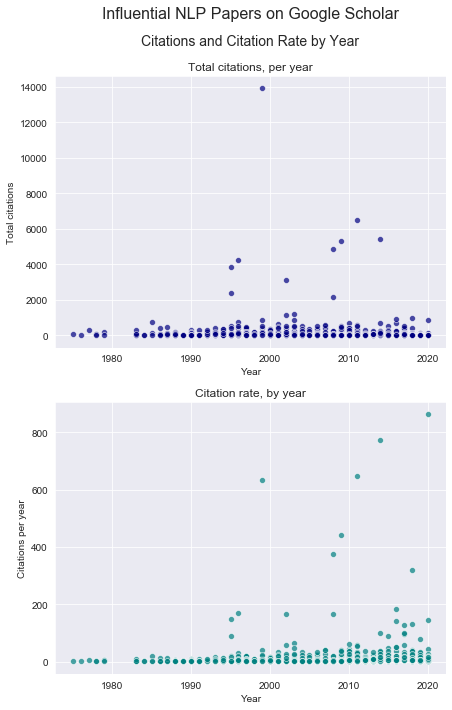

In [45]:
def plot_citations_by_year(df, title, subtitle, year_col="year"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), 
      year_col (str)
    - Plots a scatterplot of the count of citations and citation_rate 
      in df by year.
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(7, 11), nrows=2, ncols=1)

    # total citations
    sns.scatterplot(
        x="year",
        y="citations",
        data=df,
        alpha=0.7,
        color="navy",
        ax=ax0
    )
    ax0.set(
        xlabel="Year",
        ylabel="Total citations",
        title="Total citations, per year"
    )

    # total citation rate
    sns.scatterplot(
        x="year",
        y="citation_rate",
        data=df,
        alpha=0.7,
        color="teal",
        ax=ax1
    )
    ax1.set(
        xlabel="Year",
        ylabel="Citations per year",
        title="Citation rate, by year"
    )

    # titles
    ax0.text(
        x=0.5,
        y=1.20,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax0.transAxes
    )
    ax0.text(
        x=0.5,
        y=1.10,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax0.transAxes
    )
    plt.show()

subtitle = "Citations and Citation Rate by Year"
plot_citations_by_year(papers, title, subtitle)

Number of citations per year and citation rates per year look reasonably steady, but there are some interesting outliers. What happened in 1999? It looks like that was a banner year for NLP. Perhaps we will find an answer as we continue to look at the data.

## Influential Papers

Now that we have an idea of the broader trend in production of NLP papers, let's get to our key question. What are the most influential papers and books? Where should you start if you want to learn about NLP?

An obvious place to start is to look at which papers have the most citations. Generally, if a paper is widely cited in academic literature, we can reasonably say that it has been an influential paper. Let's take a look at the top 10 most cited papers.

In [50]:
def top_papers_by_col(papers_df, sort_col, limit=10):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with [limit] entries based on the highest values
      for sort_col in papers_df.
    """
    df = papers_df.copy()
    df = df.sort_values(by=sort_col, ascending=False)
    return df.head(limit)

display(top_papers_by_col(papers, "citations"))

,title,authors,blurb,citations,citation_rate,year,link
324,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,13929,633.136364,1999,https://books.google.com/books?hl=en&lr=&id=3q...
533,Natural language processing (almost) from scratch,"[R Collobert, J Weston, L Bottou, M Karlen]",We propose a unified neural network architectu...,6484,648.400000,2011,http://www.jmlr.org/papers/volume12/collobert1...
871,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel]",We describe the design and use of the Stanford...,5409,772.714286,2014,https://www.aclweb.org/anthology/P14-5010.pdf
656,Natural language processing with Python: analy...,"[S Bird, E Klein, E Loper]",This book offers a highly accessible introduct...,5304,442.000000,2009,https://books.google.com/books?hl=en&lr=&id=KG...
65,A unified architecture for natural language pr...,"[R Collobert, J Weston]",We describe a single convolutional neural netw...,4862,374.000000,2008,https://dl.acm.org/doi/abs/10.1145/1390156.139...
34,A maximum entropy approach to natural language...,"[A Berger, SA Della Pietra, VJ Della Pietra]",The concept of maximum entropy can be traced b...,4244,169.760000,1996,https://dl.acm.org/doi/abs/10.5555/234285.234289
679,Natural language understanding,[J Allen],Skip navigation \n,3823,147.038462,1995,http://125.234.102.27/handle/TVDHBRVT/15951
500,NLTK: the natural language toolkit,"[E Loper, S Bird]",3.1 Requirements Ease of Use. The primary pur...,3142,165.368421,2002,https://arxiv.org/abs/cs/0205028
910,Transformation-based error-driven learning and...,[E Brill],"Recently, there has been a rebirth of empirici...",2363,90.884615,1995,https://dl.acm.org/doi/abs/10.5555/218355.218367
179,Cheap and fast–but is it good? evaluating non-...,"[R Snow, B O'connor, D Jurafsky, AY Ng]",Human linguistic annotation is crucial for man...,2136,164.307692,2008,https://www.aclweb.org/anthology/D08-1027.pdf


The clear leader in the citation count is `Foundations of Statistical Natural Language Processing` (FSNLP) by C Manning and H Schutze, which has 13,929 citations--more than double the next contender. FSNLP was published in 1999, which would appear to solve the mystery outlier from the high-level look we took at the data earlier. If we're using citation count as our metric for influence, this data would imply that the following are the five most influential NLP papers:

* `Foundations of Statistical Natural Language Processing` by C Manning and H Schutze, with 13,929 citations;
* `Natural Language Processing (almost) from Scratch` by R Collobert, J Weston, L Bottou, and M Karlen, with 6,484 citations;
* `The Stanford CoreNLP Natural Language Processing Toolkit`, by CD Manning, M Surdeanu, J Bauer, and JR Finkel, with 5,409 citations;
* `Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit`, by S Brid, E Klein, and E Loper, with 5,304 citations; and,
* `A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning`, by R Collobert and J Weston, with 4,862 citations.

As we noted earlier though, older papers have an advantage over newer papers because they have more time to generate citations. Let's look at our other metric, the yearly citation rate, to see if we get different results.

In [48]:
display(top_papers_by_col(papers, "citation_rate"))

,title,authors,blurb,citations,citation_rate,year,link
522,Natural language processing,[KR Chowdhary],The abundant volume of natural language text i...,863,863.000000,2020,https://link.springer.com/chapter/10.1007/978-...
871,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel]",We describe the design and use of the Stanford...,5409,772.714286,2014,https://www.aclweb.org/anthology/P14-5010.pdf
533,Natural language processing (almost) from scratch,"[R Collobert, J Weston, L Bottou, M Karlen]",We propose a unified neural network architectu...,6484,648.400000,2011,http://www.jmlr.org/papers/volume12/collobert1...
324,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,13929,633.136364,1999,https://books.google.com/books?hl=en&lr=&id=3q...
656,Natural language processing with Python: analy...,"[S Bird, E Klein, E Loper]",This book offers a highly accessible introduct...,5304,442.000000,2009,https://books.google.com/books?hl=en&lr=&id=KG...
65,A unified architecture for natural language pr...,"[R Collobert, J Weston]",We describe a single convolutional neural netw...,4862,374.000000,2008,https://dl.acm.org/doi/abs/10.1145/1390156.139...
761,Recent trends in deep learning based natural l...,"[T Young, D Hazarika, S Poria]",Deep learning methods employ multiple processi...,961,320.333333,2018,https://ieeexplore.ieee.org/abstract/document/...
115,Ask me anything: Dynamic memory networks for n...,"[A Kumar, O Irsoy, P Ondruska, M Iyyer]",Most tasks in natural language processing can ...,910,182.000000,2016,http://www.jmlr.org/proceedings/papers/v48/kum...
34,A maximum entropy approach to natural language...,"[A Berger, SA Della Pietra, VJ Della Pietra]",The concept of maximum entropy can be traced b...,4244,169.760000,1996,https://dl.acm.org/doi/abs/10.5555/234285.234289
500,NLTK: the natural language toolkit,"[E Loper, S Bird]",3.1 Requirements Ease of Use. The primary pur...,3142,165.368421,2002,https://arxiv.org/abs/cs/0205028


Our top five papers by citation rate are almost the same as the top papers by total citations, with a slight re-ordering. But, we have a new entrant to the mix, and moreover, a new winner! `Natural language processing` by KR Chowdhary has the highest citation rate with 863 citations per year. Moreover, the paper was published in 2020, which means the year isn't even up!

Looking at the blurb doesn't tell us much about why this paper has been so popular, but if we follow the link to the full abstract we see that the paper is actually a chapter from KR Chowdhary's book *Fundamentals of Artificial Intelligence*. Perhaps this tells us something about the trend of NLP in general as we move from linguistic analysis to artificial intelligence applications. KR Chowdhary is a professor of computer science at Jodhpur Institute of Engineering & Technology, and based on our data, it would seem that he is one of the most influential figures in NLP and AI today.

Speaking of influential individuals, that seems like a good next step in our exploration.

## Influential Authors
One of the great things about NLP is that it benefits from the expertise of all sorts of people, ranging from computer scientists, to linguists, to specialists in other fields entirely.

To undestand who the most influential authors are, let's start by looking at who is the most prolific. While we're at it, let's see how many unique authors were involved in writing our 973 influential papers.

In [27]:
def get_author_counts(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with a count of each author in pandas_dF
    """
    authors = papers_df["authors"].apply(pd.Series
        ).stack().reset_index(name="author")
    authors = authors["author"]
    author_counts = authors.value_counts()
    author_counts = author_counts.rename_axis("author"
        ).reset_index(name="count")
    author_counts = author_counts.sort_values(by=["count", "author"], 
                                              ascending=[False, True])
    return author_counts

author_counts = get_author_counts(papers)
unique_authors = author_counts["author"].unique()

print(f"Total authors: {len(unique_authors)}\n\n")
print("Most prolific authors:")
display(author_counts.head(10))

Total authors: 1937


Most prolific authors:


,author,count
0,C Friedman,22
1,G Hripcsak,9
2,KB Cohen,8
3,E Brill,7
5,S Sohn,7
4,T Strzalkowski,7
8,H Liu,6
6,KS Jones,6
7,PJ Haug,6
9,TC Rindflesch,6


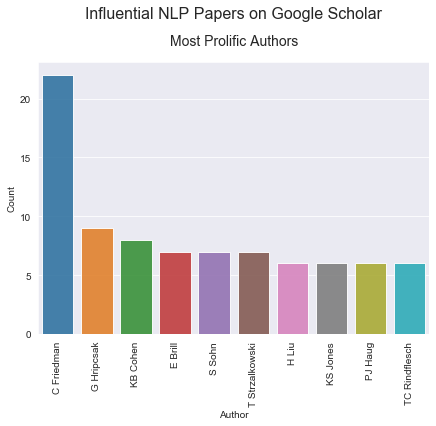

In [46]:
def plot_counts(df, title, subtitle, x_col, x_lab, y_col="count", y_lab="Count"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), x_col (str),
      x_lab (str), y_col (str), y_lab (str)
    - Plots a barplot of df using the provided x and y columns.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.barplot(
        x=x_col,
        y=y_col,
        data=df,
        alpha=0.9,
        ax=ax
    )
    ax.set(
        xlabel=x_lab,
        ylabel=y_lab,
    )
    ax.text(
        x=0.5,
        y=1.15,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    ax.text(
        x=0.5,
        y=1.05,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    plt.xticks(rotation=90)
    plt.show()

title = "Influential NLP Papers on Google Scholar"
subtitle = "Most Prolific Authors"
plot_counts(author_counts.head(10), title, subtitle, "author", "Author")

It looks like 1,937 authors contributed to our 973 papers, which makes sense since most papers have multiple authors. The most prolific author, with 22 papers, is C Friedman. So is C Friedman the most influential author? Maybe the paper titles will give us a clue.

In [30]:
def filter_by_author(papers_df, author_name):
    """
    - Parameters: papers_df (Pandas DataFrame), author_name (str)
    - Returns: A dataframe with entries from papers_df by author.
    """
    return papers_df[papers_df["authors"].apply(
        lambda authors: author_name in authors)]

c_friedman_papers = filter_by_author(papers, "C Friedman")

display(c_friedman_papers[["title", "blurb", "citations", "year"]].head(10))


,title,blurb,citations,year
22,GENIES: a natural-language processing system f...,Abstract Systems that extract structured infor...,663,2001
26,Automated encoding of clinical documents based...,Objective: The aim of this study was to develo...,547,2004
48,Unlocking clinical data from narrative reports...,Objective: To evaluate the automated detection...,410,1995
89,A broad-coverage natural language processing s...,Natural language processing systems (NLP) that...,255,2000
111,Use of natural language processing to translat...,PURPOSE: To evaluate translation of chest radi...,205,2002
118,Natural language processing and its future in ...,If accurate clinical information were availabl...,195,1999
154,Representing information in patient reports us...,Objective: To design a document model that pro...,149,1999
161,Towards a comprehensive medical language proce...,Natural language processing (NLP) systems can...,139,1997
164,Natural language processing in an operational ...,This paper describes a natural language text e...,137,1995
197,Natural language processing: state of the art ...,Natural language processing (NLP) is crucial f...,111,2013


It looks like most of C Friedman's papers are related to medical issues and bioinformatics. Unfortunately, Google Scholar doesn't tell us much about who the authors are, but a quick Internet search shows that C Friedman is Professor Carol Friedman who is a professor of biomedical informatics at Columbia University. And with so many papers to her name (several of which have hundreds of citations), she sure looks like an influential author! If you're interested in biomedical informatics, then she sounds like a good author to start with.

Of course, quantity of papers alone isn't the sole indicator of influence. What happens if we look at a different measure? Rather than evaluate total papers, let's see which author has the most citations.

In [31]:
def get_author_citation_counts(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with a citation count for each author.
    """
    df = papers_df.explode("authors")
    df = df[["authors", "citations", "citation_rate"]]
    author_citations = df.groupby("authors").sum()
    author_citations = author_citations.reset_index()
    return author_citations

author_citation_counts = get_author_citation_counts(papers)
author_citation_counts = author_citation_counts.sort_values(
    "citations", ascending=False)
display(author_citation_counts.head(10))

,authors,citations,citation_rate
268,C Manning,13960,636.580808
668,H Schutze,13929,633.136364
828,J Weston,11346,1022.400000
1431,R Collobert,11346,1022.400000
1539,S Bird,8496,611.139254
475,E Loper,8446,607.368421
1118,M Karlen,6484,648.400000
993,L Bottou,6484,648.400000
302,CD Manning,5944,861.880952
467,E Klein,5411,446.407925


The author with the most citations is C Manning with a staggering 13,960 citations. (You may recognize the name from our eralier look at most cited papers.) As we look at the top 10 authors by total citations, an interesting conundrum appears. C Manning is the top author, but another top author is CD Manning. Are they the same person? Let's look at the papers.

In [40]:
c_manning_papers = filter_by_author(papers, "C Manning")
cd_manning_papers = filter_by_author(papers, "CD Manning")

display(c_manning_papers.append(cd_manning_papers))

,title,authors,blurb,citations,citation_rate,year,link
0,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,13929,633.136364,1999,https://books.google.com/books?hl=en&lr=&id=3q...
639,Natural language processing,"[D Jurafsky, C Manning]",Much of the best work in the field combines tw...,31,3.444444,2012,https://nlp.cs.nyu.edu/meyers/montclair-class/
2,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel]",We describe the design and use of the Stanford...,5409,772.714286,2014,https://www.aclweb.org/anthology/P14-5010.pdf
30,Advances in natural language processing,"[J Hirschberg, CD Manning]",Natural language processing employs computatio...,535,89.166667,2015,https://science.sciencemag.org/content/349/624...


Once again, we're going to have to do a bit of research to determine whether C Manning and CD Manning are the same person. Now that we have the titles of the papers, a quick web search should reveal the information we need. And indeed, we can see that all four papers are co-authored by Professor Christopher D. Manning, who is a professor of machine learning, linguistics, and computer science at Stanford University and the Director of the Stanford Artificial Intelligence Laboratory. Even though Prof. Manning only has four papers in our list (plus many more not on our list), his citation count is far and away the highest. If we're looking for the most influential NLP expert, it would seem that Manning is a good candidate.

Of course, this raises the question of whether our list has other instances of authors that have two slightly different names. The answer is almost certainly yes. However, given that we have nearly 2,000 different authors, for now we'll set that question aside rather than try to research all of them.

## Learning from Experts

If the number of NLP papers being published each year is any indication, it would seem that NLP is a growing field. Here, we have only scratched the surface, both in terms of number of papers we analyzed and type of analysis. However, if you're interested in learning NLP, perhaps this data will provide you with a useful starting point. So, get reading, and let us know what you think!